# 1. Preprocessing

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def check_missing_col(dataframe):
    missing_col = []
    for col in dataframe.columns:
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            print(f'결측치가 있는 컬럼은: {col} 입니다')
            print(f'해당 컬럼에 총 {missing_values} 개의 결측치가 존재합니다.')
            missing_col.append([col, dataframe[col].dtype])
    if missing_col == []:
        print('결측치가 존재하지 않습니다')
    return missing_col

data = pd.read_csv('/content/drive/MyDrive/ML_projects/weather/back_hospital_new.csv', index_col=0)
data.columns = ['yyyymmdd', 'area', 'sex', 'frequency']
new_merge_data = pd.read_csv('/content/drive/MyDrive/ML_projects/weather/new_merge_data.csv', encoding='cp949')

## 1) 지역명 매핑

In [ ]:
# https://data.kma.go.kr/tmeta/stn/selectStnList.do?pgmNo=123
# 기상관측지점의 주소를 가져와 시도명을 매핑한다. 
area_names = pd.read_csv('/content/drive/MyDrive/ML_projects/weather/META_관측지점정보_20220701105117.csv', index_col=0)
AWS = pd.read_csv('/content/drive/MyDrive/ML_projects/weather/raw/aws/AWS.csv', encoding='cp949', index_col=0)
new_AWS = pd.merge(AWS, area_names, left_on='지점번호', right_on='지점', how='left')
new_AWS.drop(['지점', '지점명'], axis=1, inplace=True)
idxs = new_AWS['지점주소'].fillna('non fault')
new_AWS['area'] = [idx.split()[0] for idx in idxs]
def area_words(word):
    if word in ['경상북도', '충청북도', '충청남도', '경상남도', '전라북도', '전라남도']:
        word = list(word)[0] + list(word)[2]
    elif word == '서귀포시':
        word = '제주'
    elif word == 'non':
        word = word
    else:
        word = list(word)[0] + list(word)[1]
    return word 
new_AWS['area'] = [area_words(i) for i in new_AWS['area']]
#new_AWS.to_csv('/content/drive/MyDrive/ML_projects/weather/new_AWS.csv', index=False, encoding='cp949')

## 남은 100여개는 직접 매핑한다.
new_AWS_after = pd.read_csv('/content/drive/MyDrive/ML_projects/weather/new_AWS_after.csv', encoding='cp949').drop(['관리관서', '지점주소'], axis=1)
new_AWS_after.drop_duplicates(subset = ['지점번호', '지점명(한글)'],ignore_index=True, inplace=True)
new_AWS_after.drop('지점명(한글)', axis=1, inplace=True)
new_AWS_after.rename(columns={'지점번호' : 'stn_id'}, inplace=True)
new_AWS_after.to_csv('/content/drive/MyDrive/ML_projects/weather/new_AWS_final.csv', index=False, encoding='cp949')

## 2) 대기 데이터 

In [ ]:
# https://www.airkorea.or.kr/web/last_amb_hour_data?pMENU_NO=123
import math
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
lr = LinearRegression()
imp = IterativeImputer(estimator=lr,missing_values=np.nan, verbose=0, min_value = 0, imputation_order='roman',random_state=42)

path = '/content/drive/MyDrive/ML_projects/weather/raw/atmosphere/'
file_list = os.listdir(path)
func_list = ['mean'] 
data_list = []
for i in tqdm(file_list):
    res = pd.read_csv(path + i)
    data_list.append(res)
    res_data = pd.concat(data_list, axis=0, ignore_index = True)
atmo = res_data.iloc[:, [0,3,4,5,6,7,8]]
df = atmo.copy()  # SettingWithCopyWarning 회피용도
df.loc[:, 'area'] = [i.split()[0] for i in df['지역']]
df.loc[:, 'yyyymmdd'] = [math.floor(i / 100) for i in df['측정일시']]
df.drop(['지역', '측정일시'], axis=1, inplace=True)

# 이상치 -999를 평균으로 대체
col_list = ['SO2', 'CO', 'O3', 'NO2', 'PM10']
for i in col_list:
    df.loc[df[i] == -999, i] = df[df[i] != -999][i].mean()

# 결측치 대체 
df_1 = df.drop(['area', 'yyyymmdd'], axis=1)
df_2 = df[['area', 'yyyymmdd']]
X = pd.DataFrame(imp.fit_transform(df_1), columns = df.columns[0:-2])
df = pd.concat([X, df_2], axis=1)

# 날짜, 지역별 그룹화 
# 세종 시의 경우 16년도 이후의 데이터만 존재. 
df = df.groupby(['yyyymmdd', 'area'])[['SO2','CO','O3','NO2','PM10']].agg(func_list).reset_index()
df.columns = list(map('_'.join, df.columns.values))
df.rename(columns = {'yyyymmdd_' : 'yyyymmdd', 'area_' : 'area'}, inplace=True)

# 데이터 병합 
fct_forecast = pd.read_csv('/content/drive/MyDrive/ML_projects/weather/raw_2/fct_weather_merge_interpo.csv', index_col=0)
merged_data = pd.merge(fct_forecast, df, on=['yyyymmdd', 'area'], how='left')

# 세종시 NaN 데이터 처리 - 날짜별 평균
fill_mean_func = lambda g: g.fillna(g.mean())
for i in merged_data.columns[24:]:
    merged_data[i] = merged_data.groupby('yyyymmdd')[i].apply(fill_mean_func)

new_merge_data = merged_data.astype({'yyyymmdd':'int64'})
#new_merge_data.to_csv('/content/drive/MyDrive/ML_projects/weather/raw_2/new_merge_data.csv', index=False, encoding='cp949')

,yyyymmdd,area,sex,frequency,3시간기온_mean_9,3시간기온_mean_15,3시간기온_mean_21,습도_mean_9,습도_mean_15,습도_mean_21,...,강수량_mean_15,강수량_mean_21,적설_mean_9,적설_mean_15,적설_mean_21,SO2_mean,CO_mean,O3_mean,NO2_mean,PM10_mean
0,20120101,강원,1.0,3.0,-1.657143,-5.650000,-8.032143,50.642857,78.982143,83.250000,...,2.142857,0.267857,2.5,1.875,0.267857,0.010033,1.012879,0.019098,0.020873,81.045044
1,20120101,강원,2.0,3.0,-1.657143,-5.650000,-8.032143,50.642857,78.982143,83.250000,...,2.142857,0.267857,2.5,1.875,0.267857,0.010033,1.012879,0.019098,0.020873,81.045044
2,20120101,경기,1.0,4.0,-2.520000,-6.440000,-9.756667,44.400000,64.100000,79.533333,...,0.000000,0.000000,0.0,0.000,0.000000,0.009030,0.957337,0.012671,0.030729,85.113656
3,20120101,경기,2.0,5.0,-2.520000,-6.440000,-9.756667,44.400000,64.100000,79.533333,...,0.000000,0.000000,0.0,0.000,0.000000,0.009030,0.957337,0.012671,0.030729,85.113656
4,20120101,경남,1.0,2.0,2.492857,-2.101786,-4.680952,40.071429,59.803571,68.476190,...,0.000000,0.000000,0.0,0.000,0.000000,0.008975,0.653175,0.021270,0.017499,61.998255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62113,20161231,제주,2.0,NaN,8.600000,6.275000,5.650000,56.500000,64.375000,66.333333,...,5.000000,1.000000,5.0,1.000,1.000000,0.001338,0.191378,0.029063,0.012552,24.925220
62114,20161231,충남,1.0,NaN,3.216667,-0.970833,-1.831111,76.000000,88.750000,88.155556,...,5.000000,1.000000,5.0,1.000,1.000000,0.002730,0.631250,0.014071,0.022291,42.137500
62115,20161231,충남,2.0,NaN,3.216667,-0.970833,-1.831111,76.000000,88.750000,88.155556,...,5.000000,1.000000,5.0,1.000,1.000000,0.002730,0.631250,0.014071,0.022291,42.137500
62116,20161231,충북,1.0,NaN,1.516667,-0.616667,-2.432222,79.250000,82.300000,86.972222,...,5.000000,1.000000,5.0,1.000,1.000000,0.004405,0.905903,0.005111,0.026913,51.430750


# 2. EDA

## 1) dates 분리하기

In [ ]:
dates = pd.to_datetime(data.yyyymmdd, format='%Y%m%d').dt
data['year'] = dates.year
data['month'] = dates.month
data['day'] = dates.day

## 2) frequency의 시간대 별 증감


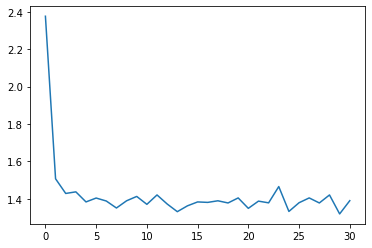

In [ ]:
wow = data.groupby(['day'])['frequency'].mean()
plt.plot(wow.values)

매월 1일과 그 이외의 데이터를 구분해 주는것이 좋아보인다.

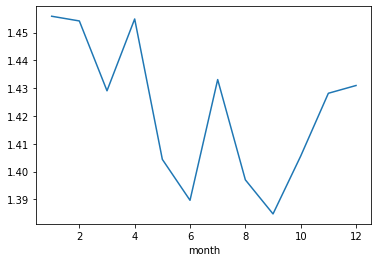

In [ ]:
wow = data.groupby(['month'])['frequency'].mean()
wow.plot()

5, 6, 8, 9월이 나머지 월에 비해 평균적으로 적은 질환 발생율을 보인다. 둘을 구분해 주는 것이 좋아보인다.

1.008857863997748
1.0082384575776646
1.0310389831470237


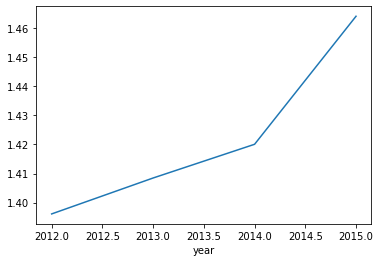

In [ ]:
year_frequency = data.groupby(['year'])['frequency'].mean()
year_frequency.plot()
print(year_frequency.values[1] / year_frequency.values[0])
print(year_frequency.values[2] / year_frequency.values[1])
print(year_frequency.values[3] / year_frequency.values[2])

연도 별로 꾸준히 증가함을 보인다. 최종 예측 시에 14-15년도의 증가분을 곱해주는 것이 좋아보인다.

## 3) 지역 별 frequency의 차이

In [ ]:
''' frequency값을 직접쓰는거라 보류 
back_merge_papulation['year'] = dates.year
back_merge_papulation['month'] = dates.month
back_merge_papulation['day'] = dates.day
back_merge_papulation['tot_person'] = pd.to_numeric(back_merge_papulation['tot_person'], errors='coerce')
pap = back_merge_papulation[back_merge_papulation['year'] != 2016]
df = pd.merge(data, pap, how='left')
df.drop('frequency', axis=1, inplace=True)

# 세종시 인구데이터 nan 처리 - backward 회귀 보간법 
def seojong_nan(dfile, sex):
    a = dfile[(dfile['area'] == '세종') & (dfile['sex'] == sex)]
    idx = a['tot_person'].interpolate(limit_direction='backward').index
    dfile.loc[idx, 'tot_person'] = a['tot_person'].interpolate(limit_direction='backward').values 

    return dfile
df = seojong_nan(df, 1)
df = seojong_nan(df, 2)

# 각 지역별 인구수가 보정된 frequency 값 
back_merge_papulation['frequency_people'] = back_merge_papulation['frequency'] / back_merge_papulation['tot_person']
wow = back_merge_papulation.groupby('area')['frequency_people'].mean()
print(wow * 10**8)  # 가시성을 위한 곱, 실제 수치에 사용하진 않는다. 
plt.plot(wow.values)

각 지역 별로 인구수를 보정한 타겟값을 살펴본다. 강원, 경남, 경북, 전남, 전북, 충북 지역의 타겟값이 다른 지역에 비해 더 높은 것을 알 수 있다. 두 집단을 구분해주는 변수를 고려해볼 수 있다.
df['areal_type'] = [1 if i in (['강원', '경남', '경북', '전남', '전북', '충북']) else 0 for i in df['area']]
'''

# 3. 최종 데이터

In [ ]:
back_merge_papulation = pd.read_csv('/content/drive/MyDrive/ML_projects/weather/back_merge_papulation_riskAge.csv', encoding='cp949')
dates = pd.to_datetime(back_merge_papulation.yyyymmdd, format='%Y%m%d').dt
back_merge_papulation['year'] = dates.year
back_merge_papulation['month'] = dates.month
back_merge_papulation['day'] = dates.day

# 고려한 변수 생성 
back_merge_papulation['day_differ'] = [1 if i == 1 else 0 for i in back_merge_papulation['day']]
back_merge_papulation['month_differ'] = [1 if i in [5,6,8,9] else 0 for i in back_merge_papulation['month']]
#back_merge_papulation.to_csv('/content/drive/MyDrive/ML_projects/weather/raw_2/hospital.csv', encoding='cp949', index=False)

In [ ]:
dff = pd.merge(back_merge_papulation, new_merge_data, how='left')
dff.to_csv('/content/drive/MyDrive/ML_projects/weather/dff.csv', index=False)

,yyyymmdd,area,sex,frequency,tot_person,num_risk_age,year,month,day,day_differ,...,강수량_mean_15,강수량_mean_21,적설_mean_9,적설_mean_15,적설_mean_21,SO2_mean,CO_mean,O3_mean,NO2_mean,PM10_mean
0,20120101,강원,1,3.0,772718.0,322636.0,2012,1,1,1,...,2.142857,0.267857,2.5,1.875,0.267857,0.010033,1.012879,0.019098,0.020873,81.045044
1,20120101,강원,2,3.0,762617.0,229447.0,2012,1,1,1,...,2.142857,0.267857,2.5,1.875,0.267857,0.010033,1.012879,0.019098,0.020873,81.045044
2,20120101,경기,1,4.0,6020446.0,2054584.0,2012,1,1,1,...,0.000000,0.000000,0.0,0.000,0.000000,0.009030,0.957337,0.012671,0.030729,85.113656
3,20120101,경기,2,5.0,5928150.0,1182747.0,2012,1,1,1,...,0.000000,0.000000,0.0,0.000,0.000000,0.009030,0.957337,0.012671,0.030729,85.113656
4,20120101,경남,1,2.0,1665308.0,622268.0,2012,1,1,1,...,0.000000,0.000000,0.0,0.000,0.000000,0.008975,0.653175,0.021270,0.017499,61.998255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62113,20161229,충북,2,NaN,788385.0,258676.0,2016,12,29,0,...,4.000000,1.500000,3.0,1.000,2.400000,0.003783,0.535764,0.012149,0.023849,37.127226
62114,20161230,충북,1,NaN,803240.0,358361.0,2016,12,30,0,...,5.000000,1.000000,5.0,1.000,1.000000,0.003835,0.654514,0.008958,0.026286,37.446657
62115,20161230,충북,2,NaN,788385.0,258676.0,2016,12,30,0,...,5.000000,1.000000,5.0,1.000,1.000000,0.003835,0.654514,0.008958,0.026286,37.446657
62116,20161231,충북,1,NaN,803240.0,358361.0,2016,12,31,0,...,5.000000,1.000000,5.0,1.000,1.000000,0.004405,0.905903,0.005111,0.026913,51.430750
